## Neural Nets using PyTorch (MNIST) & SGD

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# from fastai.imports import *
# from fastai.torch_imports import *
# from fastai.io import *

In [6]:
path = 'data/mnist/'
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

**imports from io.py since it wasn't working**

In [10]:
import gzip
from urllib.request import urlretrieve
from tqdm import tqdm

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None: self.total = tsize
        self.update(b * bsize - self.n)

def get_data(url, filename):
    if not os.path.exists(filename):

        dirname = os.path.dirname(filename)
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            urlretrieve(url, filename, reporthook=t.update_to)

In [11]:
get_data(URL+FILENAME, path+FILENAME)

mnist.pkl.gz: 16.2MB [00:03, 4.70MB/s]                            


In [12]:
data = load_mnist(path+FILENAME)

In [17]:
len(data)

3

In [18]:
data

((array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([5, 0, 4, ..., 8, 4, 8])),
 (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([3, 8, 6, ..., 5, 6, 8])),
 (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([7, 2, 1, ..., 4, 5, 6])))

In [19]:
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [20]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

In [25]:
# rank
len(x.shape)

2

### Normalize Data

In [30]:
mean = x.mean()
std = x.std()

x_norm = (x-mean)/std
mean,std,x_norm.mean(),x_norm.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

**use same mean for validation set**

In [31]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [34]:
# 10000 images in valid set, 
# each one is rank1 tensor of len 784
x_valid.shape

(10000, 784)

### Look at the data

#### Helper methods

In [39]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [40]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [51]:
x_valid.shape

(10000, 784)

In [52]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

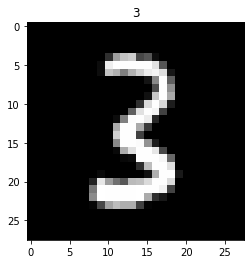

In [43]:
show(x_imgs[0], y_valid[0])

In [44]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [45]:
y_valid[0]

3

We can look at part of an image:

In [60]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

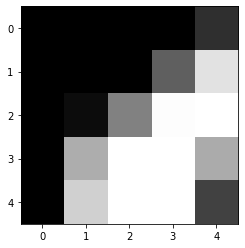

In [58]:
show(x_imgs[0,10:15,10:15])

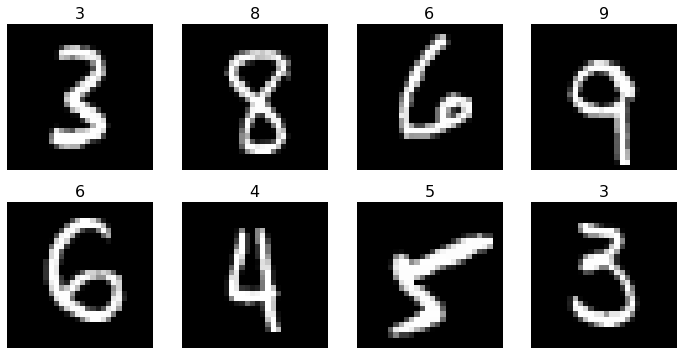

In [48]:
plots(x_imgs[:8], titles=y_valid[:8])

### PyTorch

In [66]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

**define NN with a linear layer followed by a nonlinear layer**

In [64]:
dim = 28*28
net = nn.Sequential(nn.Linear(dim,10),nn.LogSoftmax())

In [86]:
??T

Signature: T(a, half=False, cuda=True)
Source:   
def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a
File:      ~/Documents/Github/fastai_ml/ml1/fastai/core.py
Type:      function


### Loss functions
- loss function is lower when the NN predictions are better (score of how good we are)
- Negative Log Likelihood Loss (Cross-entropy)
    - binary and categorical


## Notes

- RFs are good for?
    - structured data, low to medium cardinality (num of values in a set)

- NNs good for?
    - unstructured data, high cardinaltiy data

- feather is good way to save?
    - pandas DFs (can be used not only in Python)

- pickle is a good way to save?
    - general Python objects (can be used only in Python)

- what are rows, cols called?
    - axis0, axis1, respectively
- in imaging, convention is?
    - cols by rows (axis 1 by axis 0)
    

- what is vector, 2D matrix, 3D matrix?
    - rank1, 2, and 3 tensors

- what is normalizing data?
    - subtract mean and divide by std from data so that mean is 0 and std is 1

- what is a NN?
    - universal function generator

- what is a NN made up of?
    - linear functions multiplied by nonlinear functions chained together

- What is pytorch Variable?
    - wrapper that allows a tensor to be differentiated

- what is a generator?
    - function that acts like an iterator that generates another data object (stream processing)

- what is an activation?
    - value that is calculated in a layer (it's not a weight)

In [68]:
??ImageClassifierData

Init signature: ImageClassifierData(path, datasets, bs, num_workers, classes)
Docstring:      Encapsulates DataLoaders and Datasets for training, validation, test. Base class for fastai *Data classes.
Source:        
class ImageClassifierData(ImageData):
    @classmethod
    def from_arrays(cls, path, trn, val, bs=64, tfms=(None,None), classes=None, num_workers=4, test=None, continuous=False):
        """ Read in images and their labels given as numpy arrays

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            trn: a tuple of training data matrix and target label/classification array (e.g. `trn=(x,y)` where `x` has the
                shape of `(5000, 784)` and `y` has the shape of `(5000,)`)
            val: a tuple of validation data matrix and target label/classification array.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        

#### Understanding argmax

In [72]:
a = np.array([[1,2,3,4],[5,6,7,8]])

In [73]:
a

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [77]:
a[0]

array([1, 2, 3, 4])

In [75]:
a[1]

array([5, 6, 7, 8])

In [78]:
a[:,0]

array([1, 5])

In [80]:
a[:,3]

array([4, 8])

In [84]:
# argmax returns the index of the highest value
a_max = a.argmax(axis = 0)
a_max

array([1, 1, 1, 1])